In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches

from utils import *

## Supply and Demand

In [15]:
data_URL = 'https://www.ssb.no/statbank/sq/10085910'

data = import_salmon_data(data_URL)

display(data)

date_series = pd.to_datetime(data['uke'].str[:4] + data['uke'].str[-2:] + '1', format='%Y%W%w')
data.set_index(date_series, inplace=True)
data.drop(['uke'], axis=1, inplace=True)

display(data)

,uke,Kilopris (kr),Vekt (tonn)
0,2000U02,31.12,4054
1,2000U03,31.03,4043
2,2000U04,30.95,3730
3,2000U05,31.30,3831
4,2000U06,32.53,4415
...,...,...,...
1228,2023U30,86.14,19604
1229,2023U31,83.28,20469
1230,2023U32,80.26,21060
1231,2023U33,78.14,22698


,Kilopris (kr),Vekt (tonn)
uke,,
2000-01-10,31.12,4054
2000-01-17,31.03,4043
2000-01-24,30.95,3730
2000-01-31,31.30,3831
2000-02-07,32.53,4415
...,...,...
2023-07-24,86.14,19604
2023-07-31,83.28,20469
2023-08-07,80.26,21060


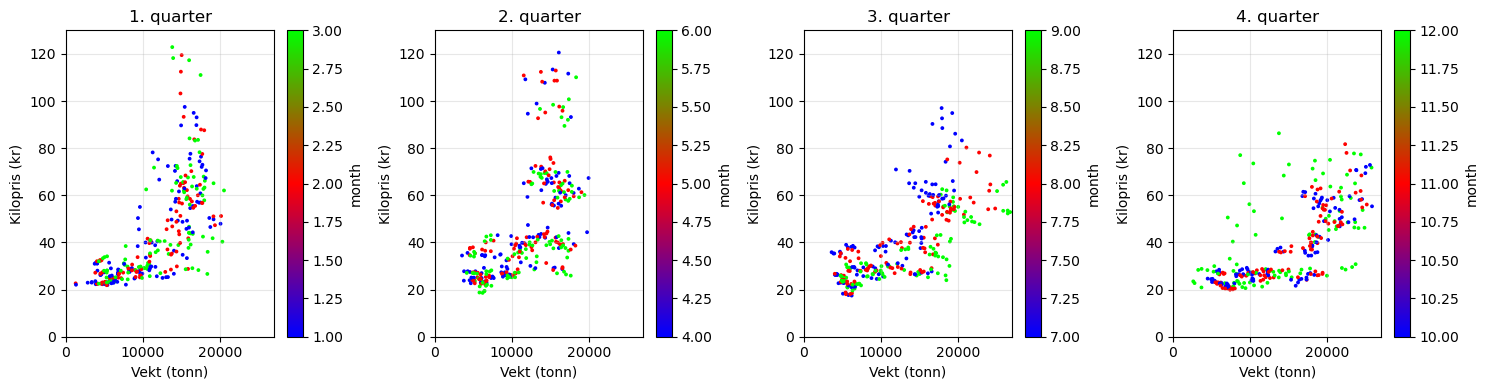

In [16]:
data['quarter'] = data.index.quarter
data['month'] = data.index.month

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

for i in range(4):
    selected = data.loc[data['quarter'] == i + 1]
    selected.plot(
        kind='scatter', 
        x='Vekt (tonn)', 
        y='Kilopris (kr)', 
        c='month', 
        cmap='brg', 
        s=3, 
        ax=axs[i]
    )

    axs[i].set_title(f'{i + 1}. quarter')
    axs[i].grid(alpha=0.3)
    axs[i].set_xlim((0, 27000))
    axs[i].set_ylim((0, 130))

fig.tight_layout()

c:\Users\joneh\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


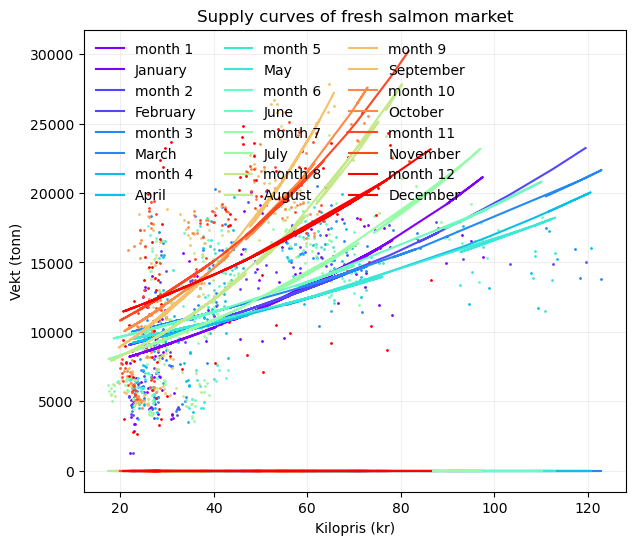

In [39]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


def log_linear_demand(price, a, b):
    return np.exp(a) * np.exp(-b * price)

def log_linear_supply(price, a, b):
    return np.exp(a) *  np.exp(b * price)

colors = plt.cm.rainbow(np.linspace(0, 1, 12))

fig, ax = plt.subplots(figsize=(7, 6))

for i, month in enumerate(data['month'].unique()):
    selected = data.loc[data['month'] == month]
    params_d, covariance_d = curve_fit(log_linear_demand, selected['Kilopris (kr)'], selected['Vekt (tonn)'])
    params_s, covariance_s = curve_fit(log_linear_supply, selected['Kilopris (kr)'], selected['Vekt (tonn)'])

    ax.plot(selected['Kilopris (kr)'], log_linear_demand(selected['Kilopris (kr)'], *params_d), label=f'month {month}', color=colors[i])
    ax.plot(selected['Kilopris (kr)'], log_linear_supply(selected['Kilopris (kr)'], *params_s), label=months[i], color=colors[i])
    ax.scatter(selected['Kilopris (kr)'], selected['Vekt (tonn)'], s=1, color=colors[i])

ax.set_title('Supply curves of fresh salmon market')
ax.set_xlabel('Kilopris (kr)')
ax.set_ylabel('Vekt (tonn)')
ax.grid(alpha=0.2)
ax.legend(ncol=3, frameon=False);

,Kilopris (kr),Vekt (tonn),quarter,month,elasticity
uke,,,,,
2000-01-10,31.12,4054,1,1,NaN
2000-01-17,31.03,4043,1,1,0.938223
2000-01-24,30.95,3730,1,1,30.028413
2000-01-31,31.30,3831,1,1,2.394447
2000-02-07,32.53,4415,1,2,3.879180
...,...,...,...,...,...
2023-07-24,86.14,19604,3,7,-1.352697
2023-07-31,83.28,20469,3,7,-1.328955
2023-08-07,80.26,21060,3,8,-0.796205


<Axes: xlabel='uke'>

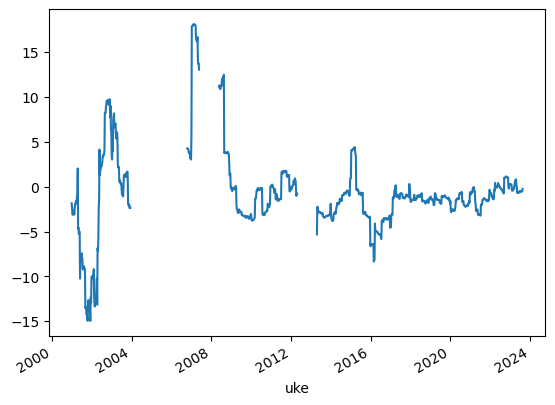

In [30]:
display(data)

data['elasticity'] = data['Vekt (tonn)'].pct_change() / data['Kilopris (kr)'].pct_change()

data['elasticity'].rolling(50).mean().plot()